In [1]:
import pandas as pd
from smileml.pipeline import (
    ColumnsSelector, UniqueCountColumnSelector, TolerantLabelEncoder, FillNaN,
    ColumnApplier, OrdinalEncoder, CountFrequencyEncoder, Logify, BoxCoxTransformer,
    YToLog)
from smileml import (compute_features_impact, compute_partial_dependence, lift_curve)
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder, Imputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, log_loss

import matplotlib.pylab as plt
%matplotlib inline
import numpy as np

In [2]:
df = pd.read_csv('./data/titanic.csv')
CAT = ['Sex', 'Embarked']
NUM = ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
df = df.iloc[np.random.permutation(len(df))]

# Model exploration
## Feature Impact

In [4]:
feature_pipeline = make_union(
    make_pipeline(
        ColumnsSelector(CAT),
        FillNaN('nan'),
        ColumnApplier(TolerantLE()),
#         TolerantLabelEncoder(),
        OneHotEncoder(sparse=False)
    ),
    make_pipeline(
        ColumnsSelector(NUM),
        Imputer()
    )
)
model = make_pipeline(
    feature_pipeline,
    LogisticRegression()
)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(df, df.Survived)
model.fit(Xtrain, Ytrain)
compute_features_impact(model, Xtest, Ytest, row_sample=100).plot(kind='barh')

ValueError: could not convert string to float: 'C'

## Partial dependence

In [5]:
help(compute_partial_dependence)

Help on function compute_partial_dependence in module smileml.impact:

compute_partial_dependence(model, Xval, features=None, row_sample=10000, percentiles=(0.05, 0.95), grid_resolution=20, n_jobs=-1)
    Compute the partial dependence (of each feature on the prediction function)
    
    For a linear model, we can look at the regression coefficients to tell whether
    a feature impacts positively or negatively the predictions
    
    For a more complex model, we use `partial dependence` to visualize this relationship
    
    The calculation may take time. To speed up you can either:
    - Use sampling with the `row_sample` parameter (in number of rows, 0 for all rows)
    - Specify the columns of interest with `features` paramters (list of columns, None for all)



In [6]:
for feature, series in compute_partial_dependence(model, Xtest, row_sample=100):
    if series.shape[0] > 0:
        if feature in CAT:
            series.plot(kind='bar')
        else:
            series.plot(kind='line')
        plt.title(feature)
        plt.show()

NameError: name 'model' is not defined

## LIFT Curve

In [6]:
lift_curve(Ytest, model.predict_proba(Xtest)[:,1])

gain      lift
decile                    
0.1     0.217822  2.207921
0.2     0.405941  1.906841
0.3     0.584158  1.806481
0.4     0.732673  1.505401
0.5     0.801980  0.671976
0.6     0.881188  0.802880
0.7     0.920792  0.401440
0.8     0.940594  0.200720
0.9     0.990099  0.501800
1.0     1.000000  0.095997

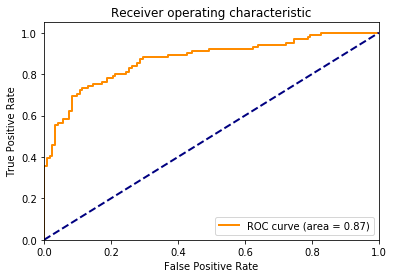

In [7]:
from smileml import plot_roc_curve
plot_roc_curve(Ytest, model.predict_proba(Xtest)[:,1])

## Explaining the prediction

In [31]:
from smileml.lime import PredictorLime
explainer = PredictorLime(Xtrain[NUM + CAT], Ytrain, NUM, CAT, class_names=['Dead', 'Alive'])

ImportError: No module named 'lime'

In [9]:
instance = Xtrain.iloc[100]
exp = explainer.explain_instance(instance, model.predict_proba, n_features=4)
exp.show_in_notebook()

/Users/phi/anaconda/envs/env35/lib/python3.5/site-packages/dodoml-0.1.0-py3.5.egg/dodoml/lime.py:207: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  scaled_data.iloc[0].reshape(1, -1),


In [10]:
# To get all the values
reason = [b for a in exp.as_list() for b in a]
values = [exp.domain_mapper.feature_values[i[0]] for i in exp.local_exp[1]]
variables = [exp.domain_mapper.feature_names[i[0]] for i in exp.local_exp[1]]

[exp.predict_proba[1]] + variables + reason + values

[0.087818079891365794,
 'Sex',
 'Pclass',
 'Age',
 'SibSp',
 'Sex=male',
 -0.47826663354407917,
 '2.00 < Pclass <= 3.00',
 -0.22371938678303924,
 'Age > 38.00',
 -0.13685454105417139,
 'SibSp <= 0.00',
 0.06829050738543771,
 'male',
 '3',
 '70.5',
 '0']

# Hyperband

## Simple xgboost hyperband

In [11]:
from xgboost import XGBClassifier

In [12]:
from smileml.ml import xgboost_hyperband_classifier, xgboost_hyperband_regressor

model = xgboost_hyperband_classifier(NUM, CAT)
model.fit(Xtrain, Ytrain)
roc_auc_score(Ytest, model.predict_proba(Xtest)[:, 1])

/Users/phi/anaconda/envs/env35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.86020938159389715

## Simple light gbm hyperband

In [13]:
from smileml.ml import lgbm_hyperband_classifier

model = lgbm_hyperband_classifier(NUM, CAT)
model.fit(Xtrain, Ytrain)
roc_auc_score(Ytest, model.predict_proba(Xtest)[:, 1])

0.84729359369647139

In [14]:
from smileml.ml import lgbm_hyperband_regressor

model = lgbm_hyperband_regressor(NUM, CAT)
model.fit(Xtrain, Ytrain)
model.predict(Xtest)[:5]

array([ 0.88247506,  0.18958641,  1.05143824,  0.13806815,  1.05673215])

## Hyperband

In [15]:
from smileml.ml import Hyperband, ContinuableLGBMClassifier
from scipy.stats.distributions import uniform, randint

param_space = {
    'max_depth': randint(2, 11),
    'min_child_weight': randint(1, 11),
    'subsample': uniform(0.5, 0.5),
}

model = make_pipeline(
    feature_pipeline,
    Hyperband(
        ContinuableLGBMClassifier(learning_rate=0.1),
        feat_space=param_space,
        task='classification'
    )
)

model.fit(Xtrain, Ytrain)
roc_auc_score(Ytest, model.predict_proba(Xtest)[:, 1])

0.84219767043508043

In [16]:
from lightgbm import LGBMClassifier
model = make_pipeline(feature_pipeline, LGBMClassifier(n_estimators=101))
model.fit(Xtrain, Ytrain)
roc_auc_score(Ytest, model.predict_proba(Xtest)[:, 1])

0.85071942446043158

In [17]:
from lightgbm import LGBMClassifier
model = make_pipeline(
    feature_pipeline,
    Hyperband(
        LGBMClassifier(learning_rate=0.1),
        feat_space=param_space,
        task='classification'
    )
)

model.fit(Xtrain, Ytrain)
roc_auc_score(Ytest, model.predict_proba(Xtest)[:, 1])

0.85735697156560464

# Correlation

## ACE correlation vs target
http://www.stat.cmu.edu/~ryantibs/datamining/lectures/11-cor2-marked.pdf

In [18]:
from smileml import compute_ace, compute_pairwise_ace

compute_ace(df, NUM, CAT, 'Survived', True)

Ace      Feature
0  0.543351          Sex
3  0.339604       Pclass
7  0.300592         Fare
1  0.151982     Embarked
4  0.089782          Age
5  0.059593        SibSp
6  0.025657        Parch
2  0.006677  PassengerId

## Pairwise ACE correlations

/Users/phi/anaconda/envs/env35/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


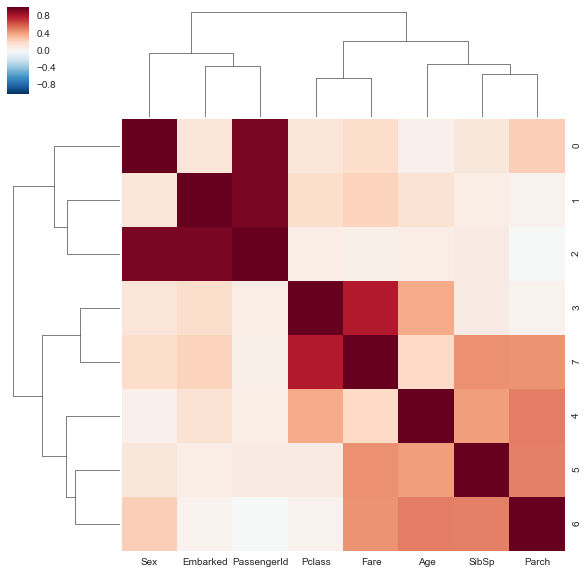

In [19]:
import seaborn as sns
sns.clustermap(compute_pairwise_ace(df, NUM, CAT))

# Pipeline Operations
## Columns Selector

In [4]:
ColumnsSelector(CAT).fit_transform(df)[:3]

Sex Embarked
434    male        S
627  female        S
606    male        S

## Columns selector based on unique count

In [5]:
UniqueCountColumnSelector(1, 5).fit_transform(df)[:3]

Survived  Pclass     Sex Embarked
434         0       1    male        S
627         1       1  female        S
606         0       3    male        S

## Label Encoder

In [6]:
TolerantLabelEncoder().fit_transform(df.Sex)[:3]

434    1
627    2
606    1
Name: Sex, dtype: int64

In [7]:
ColumnApplier(TolerantLabelEncoder()).fit_transform(df[CAT].fillna(''))[:3]

TypeError: Cannot clone object '<dodoml.pipeline.TolerantLabelEncoder object at 0x7f16b7472e80>' (type <class 'dodoml.pipeline.TolerantLabelEncoder'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

## Ordinal encoder

In [8]:
OrdinalEncoder(200).fit_transform(df[CAT])[:4]

array([[0, 0],
       [1, 0],
       [0, 0],
       [1, 0]])

## Frequency encoder

In [9]:
CountFrequencyEncoder().fit_transform(df.Sex)[:4]

array([577, 314, 577, 314])

In [10]:
ColumnApplier(CountFrequencyEncoder()).fit_transform(df[CAT])[:4]

Sex  Embarked
0  577       644
1  314       644
2  577       644
3  314       644

## Binary encoder

In [11]:
import category_encoders as ce

ce.BinaryEncoder().fit_transform(df[['Embarked']])[:3]

Embarked_0  Embarked_1
503         0.0         0.0
668         0.0         0.0
548         0.0         0.0

In [12]:
make_pipeline(
    ColumnsSelector(CAT),
    ce.BinaryEncoder()
).fit_transform(df)[:3]

Sex_0  Embarked_0  Embarked_1
503      0         0.0         0.0
668      1         0.0         0.0
548      1         0.0         0.0

## More on category_encoder

https://github.com/scikit-learn-contrib/categorical-encoding
- ce.BackwardDifferenceEncoder
- ce.BinaryEncoder
- ce.HashingEncoder
- ce.HelmertEncoder
- ce.OneHotEncoder
- ce.OrdinalEncoder
- ce.SumEncoder
- ce.PolynomialEncoder
- ce.BaseNEncoder
- ce.LeaveOneOutEncoder

## Log transformation

In [29]:
Logify().transform(df.Age)[:4]

844    1.269046
258    1.563244
821    1.456062
298         NaN
Name: Age, dtype: float64

## Boxcox transformation

In [30]:
BoxCoxTransformer().fit_transform(df.Age.fillna(-1))[:10]

array([-1.12148917, -0.68943678, -0.86048347, -2.37715597, -0.42115825,
       -0.93201806, -0.55738206, -1.00880565, -1.03576253, -2.37715597])

## Y transformation

In [31]:
model = YToLog(LinearRegression(), 0.0001)
X, y = df[['Age', 'Pclass']].fillna(0), df.Fare
model.fit(X, y)
model.predict(X)[:10]

/Users/phi/anaconda/envs/env35/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


array([  9.3626047 ,  39.85238423,   9.58654808,  36.6880905 ,
        20.44388076,   9.51880839,  40.51726743,   9.45154736,
         9.42923279,   8.99384124])

# Other tools
## Extreme Learning Machine

In [19]:
from smileml.ml.random_layer import GRBFRandomLayer, MLPRandomLayer, RandomLayer

model = make_pipeline(
    feature_pipeline,
    GRBFRandomLayer(n_hidden=1000),
    LogisticRegression()
)
cross_val_score(model, df, df.Survived, scoring='roc_auc', cv=4)

## Random Bits Features

In [18]:
from smileml.ml.randombits import RandomBitFeatures
from smileml.ml.preprocessing import simple_proc_for_linear_algoritms
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(
    simple_proc_for_linear_algoritms(NUM, CAT),
    StandardScaler(),
    RandomBitFeatures(10000),
    LogisticRegression(solver='lbfgs'))

cross_val_score(pipe, df, df.Survived, scoring='roc_auc', cv=4)

/home/tu/miniconda3/envs/myenv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


KeyboardInterrupt: 

In [25]:
pipe.fit(Xtrain, Ytrain)
compute_features_impact(pipe, Xtest, Ytest, n_jobs=-1)

[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.9s finished


Sex            0.244816
Pclass         0.079703
Age            0.067719
Fare           0.023968
PassengerId    0.019212
Parch          0.017215
SibSp          0.013696
Embarked       0.011128
Cabin          0.000000
Ticket         0.000000
Name           0.000000
Survived       0.000000
dtype: float64

In [34]:
ef = pd.read_csv('/Users/phi/Downloads/eyedetection.csv')
ef = ef.iloc[np.random.permutation(len(ef))]
efnum = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
pipe = make_pipeline(
    ColumnsSelector(efnum),
    StandardScaler(),
    RandomBitFeatures(20000),
    LogisticRegression(solver='lbfgs')
)

cross_val_score(pipe, ef, ef.TARGET, scoring='accuracy')

KeyboardInterrupt: 

In [ ]:
etrain, etest = train_test_split(ef, test_size=0.3)
pipe = lgbm_hyperband_classifier(efnum, [])
pipe.fit(etrain, etrain.TARGET)
params = pipe.steps[-1][1].best_model.get_params()
del params['_Booster']
pipe = make_pipeline(
    ColumnsSelector(efnum),
    LGBMClassifier(**params)
)
cross_val_score(pipe, ef, ef.TARGET, scoring='accuracy')

In [17]:
pipe = make_pipeline(
    ColumnsSelector(efnum),
    LGBMClassifier(n_estimators=100)
)
cross_val_score(pipe, ef, ef.TARGET, scoring='accuracy')

NameError: name 'efnum' is not defined

In [15]:
make_union(
    make_pipeline(
        ColumnsSelector(['Sex', 'Embarked', 'Pclass']),
        ce.OneHotEncoder()
    )
).fit_transform(df).sum(axis=0)

array([[1, 0, 0, ..., 0, 0, 3],
       [0, 1, 0, ..., 0, 0, 3],
       [0, 1, 0, ..., 0, 0, 3],
       ..., 
       [1, 0, 0, ..., 0, 0, 3],
       [0, 1, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 3]])